# MovieLens 1m Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
# path = 'data/ml-100k/'  # if the files are local
path = 'data/ml-1m/'  # ML-1m file
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [8]:
def get_baseline(df, train_index, test_index):
    
    '''
    Calculate baseline features from an explicit ratings dataset. Receives a dataframe
    and returns train and test splits with added bias column and mean rating value.
    User and item biases are calculated as average difference from global mean rating.
    Baseline factors are only calculated from training observations, with users or
    items that do not appear in train receiving the global average as default.
    
    Args:
        df          : explicit ratings dataframe with columns userId, movieId and rating
        train_index : train index splits taken from KFold.splits()
        test_index  : test index splits taken from KFold.splits()
        
    Returns:
        train, test : train/test splits of df, with added bias column
        global_mean : average rating of all training observations
    '''
    
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    # compute global mean
    global_mean = train.rating.mean()

    # compute average item ratings
    item_averages = train.groupby(
        'movieId'
    ).agg(
        {'rating':'mean'}
    ).rename(
        {'rating': 'item_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, item_averages, how='left', on='movieId')
    test = pd.merge(test, item_averages, how='left', on='movieId').fillna(global_mean)
    
    # compute average user bias
    train['user_bias'] = train['rating'] - train['item_avg']
    
    user_biases = train.groupby(
        'userId'
    ).agg(
        {'user_bias':'mean'}
    ).rename(
        {'user_bias': 'user_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, user_biases, how='left', on='userId')
    test = pd.merge(test, user_biases, how='left', on='userId').fillna(0.0)
    
    # interaction bias
    train['bias'] = (train['user_avg'] + train['item_avg'] - global_mean)/2
    test['bias'] = (test['user_avg'] + test['item_avg'] - global_mean)/2
    
    return train, test, global_mean

---
# Genre model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [9]:
def compile_genre_model(n_items, n_users, mean_rating, n_latent, n_hidden_1, n_hidden_2, dropout_1=.25, dropout_2=.25):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_latent)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_latent)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # concatenate user and item vectors
    conc = Concatenate()([item_vec, user_vec])
    # hidden layer
    hidden_1 = Dense(n_hidden_1)(conc)
    leaky = LeakyReLU(alpha=.1)(hidden_1)
    drop_1 = Dropout(dropout_1)(leaky)
    
    out = Dense(1)(drop_1)
            
    rating = tf.math.add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # model 2
    hidden_2 = Dense(n_hidden_2, activation='relu')(item_vec)
    drop_2 = Dropout(dropout_2)(hidden_2)
    genre = Dense(1, activation='sigmoid')(drop_2)

    # Create model and compile it
    model2 = Model(item_in, genre)
    # freeze the embedding layer
    model2.layers[1].trainable = False
    model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy', 'AUC'])
    
    return model, model2

## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

In [10]:
# hyper parameters
HP_N_FACTORS = [80, 125]
HP_N_HIDDEN_1 = [50, 75]
# HP_DROPOUT_1 = [.2, .25]
HP_N_HIDDEN_2 = [50, 75]
# HP_DROPOUT_2 = [0, .2, .25]

In [11]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting CGT model #{searches} with {N_FACTORS}: {N_HIDDEN_1} | {N_HIDDEN_2} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss = 0
            total_acc = 0
            count = 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items = df.movieId.nunique(),
                    n_users = df.userId.nunique(),
                    mean_rating = df.rating.mean(),
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    n_hidden_2=N_HIDDEN_2
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=1024,
                    epochs=8,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=64,
                    epochs=6,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                fold_acc = np.max(result.history['val_accuracy'])
                total_acc += fold_acc
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                count += 1
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'val_epochs':min_epochs,
                                 'train_loss_hist':result.history['loss'],
                                 'val_loss_hist':result.history['val_loss'],
                                 'train_acc_hist':result.history['accuracy'],
                                 'val_acc_hist':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 8 models

Fitting CGT model #1 with 80: 50 | 50 architecture
_____________________________________CV avg val loss=0.7787
_____________________________________CV avg val acc=0.6645

Fitting CGT model #2 with 80: 50 | 75 architecture
_____________________________________CV avg val loss=0.7770
_____________________________________CV avg val acc=0.6672

Fitting CGT model #3 with 80: 75 | 50 architecture
_____________________________________CV avg val loss=0.7749
_____________________________________CV avg val acc=0.6678

Fitting CGT model #4 with 80: 75 | 75 architecture
_____________________________________CV avg val loss=0.7659
_____________________________________CV avg val acc=0.6870

Fitting CGT model #5 with 125: 50 | 50 architecture
_____________________________________CV avg val loss=0.7730
_____________________________________CV avg val acc=0.6681

Fitting CGT model #6 with 125: 50 | 75 architecture
_____________________________________CV avg val loss=0.7719
_____

In [12]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
3,80,75,75,0.765946,0.686957,5,"[0.6530380110511894, 0.6134247471546305, 0.604...","[0.6158727882862806, 0.5970114519571078, 0.585...","[0.62031484, 0.6656672, 0.672039, 0.68028486, ...","[0.64767617, 0.6671664, 0.67466265, 0.68065965..."
7,125,75,75,0.768324,0.676762,5,"[0.652388553301255, 0.60962348282784, 0.596452...","[0.6157294295538311, 0.5948262816068829, 0.586...","[0.6109445, 0.6697901, 0.67841077, 0.6851574, ...","[0.64167917, 0.65817094, 0.6671664, 0.6716642,..."
6,125,75,50,0.771078,0.678561,5,"[0.6493602092119528, 0.6152935738506345, 0.603...","[0.6182770612000347, 0.6020780097598257, 0.593...","[0.6330585, 0.6634183, 0.6817841, 0.68928033, ...","[0.6491754, 0.65817094, 0.66866565, 0.67616194..."
5,125,50,75,0.771865,0.678261,4,"[0.642809342766094, 0.6059474682343239, 0.5939...","[0.6101881892069884, 0.5928538596254774, 0.583...","[0.6371814, 0.6690405, 0.6795352, 0.6896552, 0...","[0.6656672, 0.67466265, 0.6791604, 0.6791604, ..."
4,125,50,50,0.773037,0.668066,5,"[0.646270739442405, 0.6161790194361285, 0.6054...","[0.6186135043983517, 0.601289589544465, 0.5915...","[0.6278111, 0.6596702, 0.67391306, 0.6832833, ...","[0.6311844, 0.64467764, 0.66416794, 0.66866565..."
2,80,75,50,0.774935,0.667766,5,"[0.6744230894491948, 0.6334921795388927, 0.620...","[0.6454096589310059, 0.6199964948858636, 0.611...","[0.56409293, 0.63568217, 0.65404797, 0.6626686...","[0.62068963, 0.63868064, 0.65817094, 0.6566716..."
1,80,50,75,0.777037,0.667166,5,"[0.6497601007950539, 0.6202203246249609, 0.612...","[0.6178590546304854, 0.6056882588044814, 0.597...","[0.63268363, 0.64392805, 0.66041976, 0.6634183...","[0.64167917, 0.64767617, 0.6431784, 0.65067464..."
0,80,50,50,0.778724,0.664468,5,"[0.638618492293751, 0.6153440952658474, 0.6065...","[0.6181838074545453, 0.6066977701623222, 0.600...","[0.6473014, 0.65404797, 0.67241377, 0.6735382,...","[0.6311844, 0.64467764, 0.65667164, 0.66266865..."


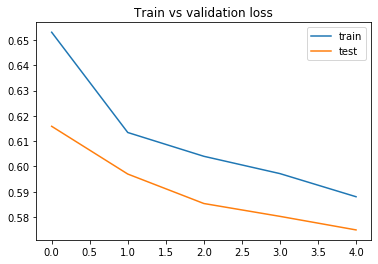

In [13]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

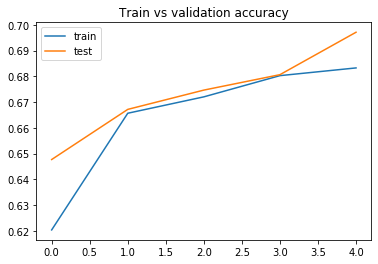

In [14]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='test')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [15]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors     80
n_hidden_1    75
n_hidden_2    75
Name: 3, dtype: object

## Classification report

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [17]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=512,
    epochs=8,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=32, 
    epochs=7)

Train on 800167 samples, validate on 200042 samples
Epoch 1/10
800167/800167 [==============================] - 35s 44us/sample - loss: 0.8162 - val_loss: 0.8712
Epoch 2/10
800167/800167 [==============================] - 37s 46us/sample - loss: 0.7738 - val_loss: 0.8737
Epoch 3/10
800167/800167 [==============================] - 37s 46us/sample - loss: 0.7532 - val_loss: 0.8763
Epoch 4/10
800167/800167 [==============================] - 35s 43us/sample - loss: 0.7366 - val_loss: 0.8808
Epoch 5/10
800167/800167 [==============================] - 37s 46us/sample - loss: 0.7207 - val_loss: 0.8807
Epoch 6/10
800167/800167 [==============================] - 39s 48us/sample - loss: 0.7064 - val_loss: 0.8881
Epoch 7/10
800167/800167 [==============================] - 36s 45us/sample - loss: 0.6938 - val_loss: 0.8872
Epoch 8/10
800167/800167 [==============================] - 36s 45us/sample - loss: 0.6826 - val_loss: 0.8870
Epoch 9/10
800167/800167 [==============================] - 36s 45us

### Evaluate on test set
**Best**: 70% with 80 : 75 | 75 hparams

In [33]:
# class proportions
movies_holdout.Drama.value_counts()/len(movies_holdout)

0    0.61186
1    0.38814
Name: Drama, dtype: float64

In [18]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       227
           1       0.61      0.62      0.61       144

    accuracy                           0.70       371
   macro avg       0.68      0.68      0.68       371
weighted avg       0.70      0.70      0.70       371



In [20]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,170,57
1,55,89
